## Урок 4. Алгоритм построения дерева решений

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [4]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

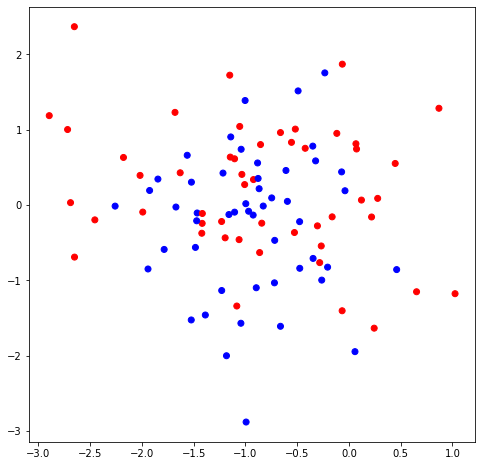

In [5]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, num_features, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    #min_leaf = 5

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    #n_features = data.shape[1] # кол-во признаков
    if num_features > data.shape[1]:
        num_features = data.shape[1]
    
    for index in range(num_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

#def build_tree(data, labels):
def build_tree(data, labels, num_features, min_leaf):
    
    quality, t, index = find_best_split(data, labels, num_features, min_leaf) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, num_features, min_leaf)
    false_branch = build_tree(false_data, false_labels, num_features, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [14]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [15]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [16]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [17]:
def get_analyze(n_features, min_leaf, train_data=train_data,test_data=test_data,
              train_labels=train_labels,test_labels=test_labels):
    tree = build_tree(train_data, train_labels, n_features, min_leaf)
    train_res = predict(train_data, tree)
    test_res = predict(test_data, tree)
    train_acc = accuracy_metric(train_labels, train_res)
    test_acc = accuracy_metric(test_labels, test_res)
    print(f'Кол.признаков: {n_features}, Мин. листов: {min_leaf}')
    print(f'Точность не трейне: {train_acc:.3f}, на тесте: {test_acc:.3f}')

In [18]:
for i in range(2,6):
    for j in (6, 7, 10, 11, 12, 15, 17, 20):
        get_analyze(i, j)
        print()

Кол.признаков: 2, Мин. листов: 6
Точность не трейне: 82.857, на тесте: 53.333

Кол.признаков: 2, Мин. листов: 7
Точность не трейне: 81.429, на тесте: 60.000

Кол.признаков: 2, Мин. листов: 10
Точность не трейне: 80.000, на тесте: 56.667

Кол.признаков: 2, Мин. листов: 11
Точность не трейне: 71.429, на тесте: 46.667

Кол.признаков: 2, Мин. листов: 12
Точность не трейне: 70.000, на тесте: 66.667

Кол.признаков: 2, Мин. листов: 15
Точность не трейне: 68.571, на тесте: 63.333

Кол.признаков: 2, Мин. листов: 17
Точность не трейне: 68.571, на тесте: 60.000

Кол.признаков: 2, Мин. листов: 20
Точность не трейне: 64.286, на тесте: 53.333

Кол.признаков: 3, Мин. листов: 6
Точность не трейне: 82.857, на тесте: 53.333

Кол.признаков: 3, Мин. листов: 7
Точность не трейне: 81.429, на тесте: 60.000

Кол.признаков: 3, Мин. листов: 10
Точность не трейне: 80.000, на тесте: 56.667

Кол.признаков: 3, Мин. листов: 11
Точность не трейне: 71.429, на тесте: 46.667

Кол.признаков: 3, Мин. листов: 12
Точность н

Увеличение количества признаков положительно влияет на обучение модели: растет качество на тестовой выборке и практически не изменяется обучающей. Можно сделать вывод, что степень переобучения падает с увеличением количества признаков. Минимальное количество листьев нуждается в подборе, т.к. его недостаток ведет к недообучению, а избыток к переобучению.